# Visualization

In [1]:
%reload_ext autoreload
%autoreload 3

import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import shap


## SHAP Plots

In [2]:
# open shap data 
with open('data/classification_results/shap_values_stratifiedCV_shuffled.pkl', 'rb') as f:
    _shap_values = pickle.load(f)

# sift out shap, y_pred, y_test values
shap_keys = list(_shap_values.keys())[:3]
y_preds_keys = list(_shap_values.keys())[3:6]
y_test_keys = list(_shap_values.keys())[6:9]
test_indices_keys = list(_shap_values.keys())[9:12]

shap_values = {k:_shap_values[k] for k in shap_keys}
y_preds = {k[7:]:_shap_values[k] for k in y_preds_keys} # remove 'y_pred_'
y_tests = {k[7:]:_shap_values[k] for k in y_test_keys} # remove 'y_test_'
test_indices = {k[len('test_indices_'):]:_shap_values[k] for k in test_indices_keys} # remove 'test_indices_'

In [3]:
# open data
# beta correlation source
correlation = pd.read_csv('data/classification_datasets/correlation_source.csv', index_col=0)
correlation = correlation.query('description == "hypnosis"')
correlation = correlation.query('condition.str.contains("experience")').reset_index(drop=True)
col_name = [col for col in correlation.columns if 'beta' in col]
correlation_beta = correlation[col_name]

# gamma power sensor
power = pd.read_csv('data/classification_datasets/power_sensor.csv', index_col=0)
power = power.query('description == "hypnosis"')
power = power.query('condition.str.contains("experience")').reset_index(drop=True)
col_name = [col for col in power.columns if 'gamma' in col]
power_gamma = power[col_name]

### Swarm Plots
Summary plots with correctly classified and misclassified groups separated.

In [5]:
# pd.set_option('display.max_rows', 20)
model_name = 'power sensor (gamma)'

values = shap_values[model_name].values

df = pd.DataFrame(data=values, columns=power_gamma.columns)

df['y_pred'] = y_preds[model_name]
df['y_test'] = y_tests[model_name]
df['hit'] = df['y_pred'] == df['y_test']

# # sort values by the mean of each column (last row)
# df = df.append(df.abs().mean(axis=0), ignore_index=True)
# df.sort_values(by=4120, axis=1, ascending=False, inplace=True)

14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
41.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


<AxesSubplot:xlabel='value', ylabel='feature'>

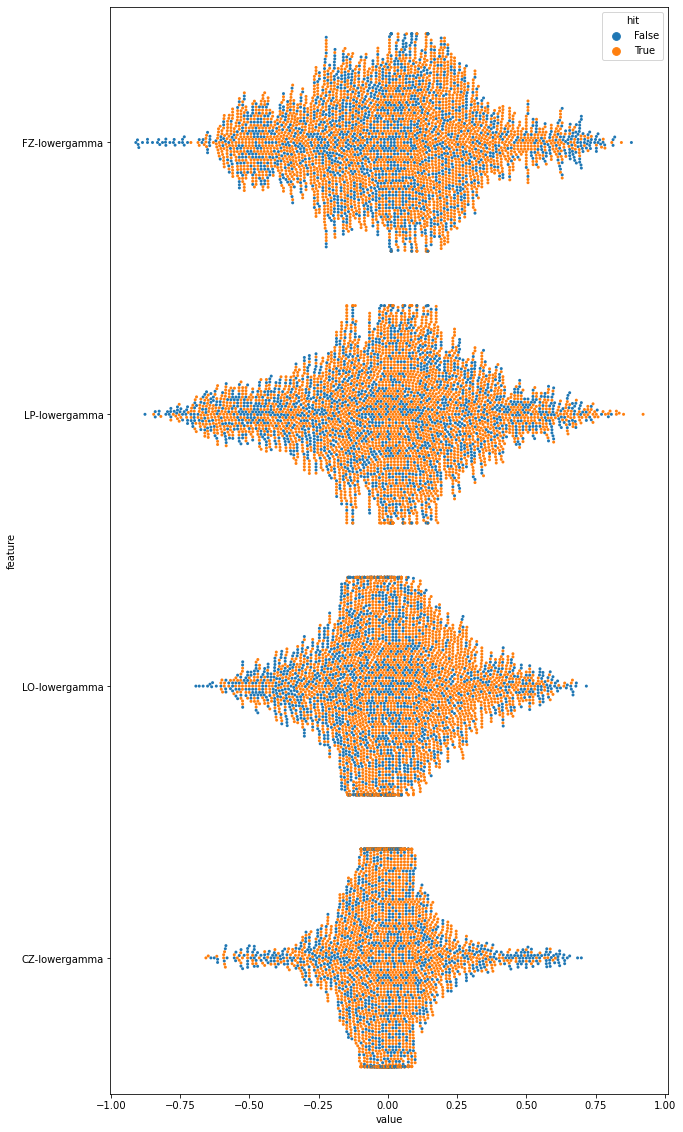

In [56]:
fig, ax = plt.subplots(figsize=(10,20))

df1 = pd.melt(df,
              id_vars=['hit'],
              value_vars=['FZ-lowergamma', 'LP-lowergamma','LO-lowergamma', 'CZ-lowergamma'],
              var_name='feature')

sns.swarmplot(x='value', y='feature', hue='hit', data=df1, size=3)

### Bar plots
Bar plots with correctly classified and misclassified groups separated.

<AxesSubplot:>

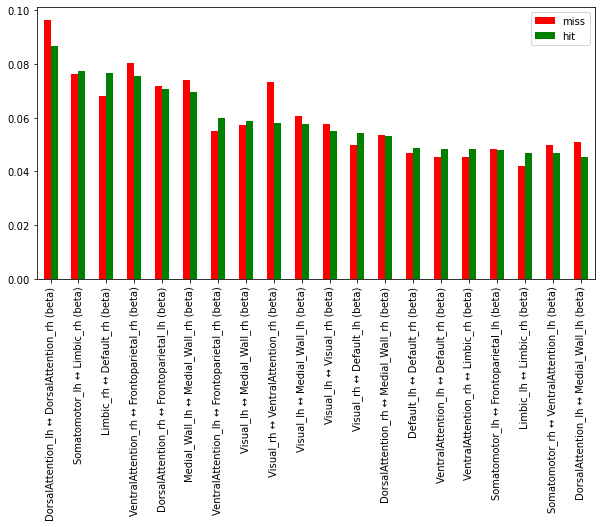

In [18]:
from matplotlib.pyplot import axis


model_name = 'correlation source (beta)'
data = correlation_beta

miss_idx = np.where(y_preds[model_name] != y_tests[model_name])[0]
miss = np.abs(shap_values[model_name].values[miss_idx]).mean(axis=0)
hit = np.abs(np.delete(shap_values[model_name].values, miss_idx, axis=0)).mean(axis=0)

df = pd.DataFrame({'miss':miss,
                   'hit': hit},
                   index=data.columns)

df.sort_values('hit', ascending=False)[:20].plot(kind='bar', stacked=False, figsize=(10,5), color=['red', 'green'])

Is there a reason why each feature contributes more to misclassification than classification?
Two reasons may explain this:
1. The task (being in the resting state) did not create a contrast between two groups; iin other words, each feature lacks the distinctive power.
2. There are many features that create hypnotic experiences, so when the model learns an increase in one feature will indicate a participant belongs to a particular group, it doesn't always happen.
3. The relationship between that feature and the target value may not be linear.

### Summary Plots
"This plot is made of many dots. Each dot has three characteristics:
- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction."

For example, the point in the upper left was for a person with a low connections between left and right DorsalAttention networks, reducing the prediction by 0.5.

We cannot know from this graph, if that person was miscalssifeid or correctly classified.

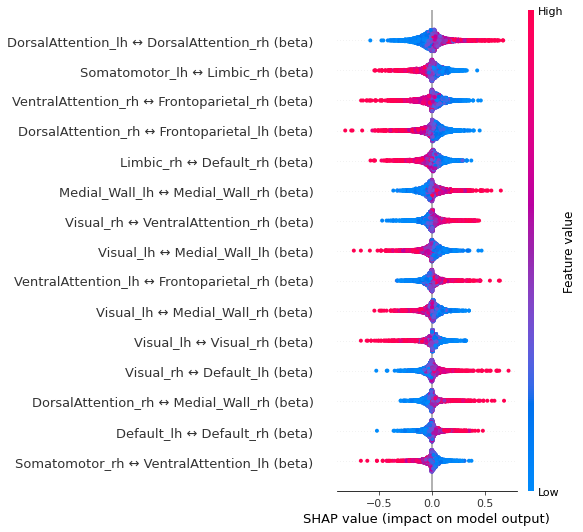

In [7]:
model_name = 'correlation source (beta)'
shap.summary_plot(shap_values[model_name], max_display=15)

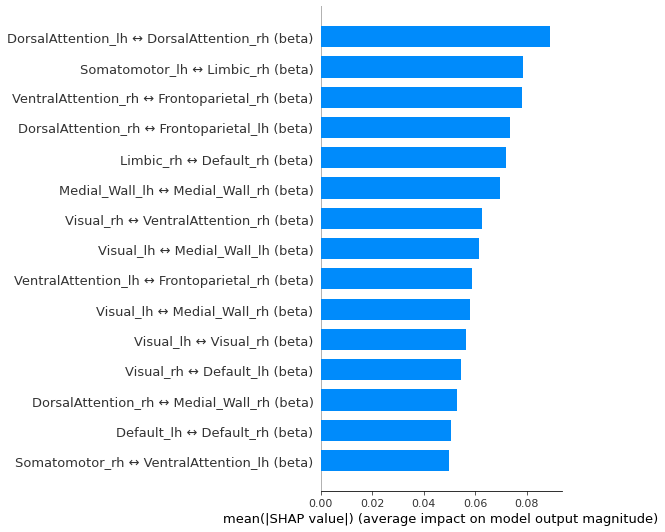

In [8]:
shap.summary_plot(shap_values[model_name], plot_type='bar', max_display=15)

### Dependence plot
The spread suggests that other features must interact with this feature.

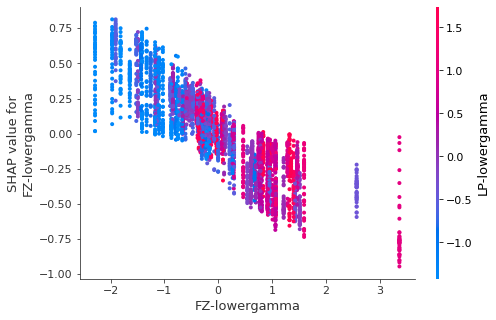

In [6]:
model_name = 'power sensor (gamma)'
# create a dataframe from shap value data
data = pd.DataFrame(shap_values[model_name].data, columns=power_gamma.columns)
col = ['Somatomotor_lh ↔ Limbic_rh (beta)', 'DorsalAttention_lh ↔ DorsalAttention_rh (beta)']

shap.dependence_plot('FZ-lowergamma',
                     shap_values[model_name].values,
                     data,
                     interaction_index= 'LP-lowergamma',
                     )

### Force Plot

In [6]:
# force plot
shap.initjs()

model_name = 'power sensor (gamma)'
i = 3  # participant index

shap.force_plot(shap_values[model_name].base_values[i],
                shap_values[model_name].values[i],
                shap_values[model_name].data[i])

### Decision Plot
First, we plot the decision tree for the hypnotized participants who were classified as non-hypnotized. (in how many ways are the high participants misclassified?)

#### Decision of the misclassified participants
TODO Compare decision plot with force plot. 

In [ ]:
# Find constantly misclassified observations
model_name = 'power sensor (gamma)'

misclassified = np.where(y_tests[model_name] != y_preds[model_name])[0]
misclassified_obs = [i for i in range(103) if i in misclassified] # misclassified observations

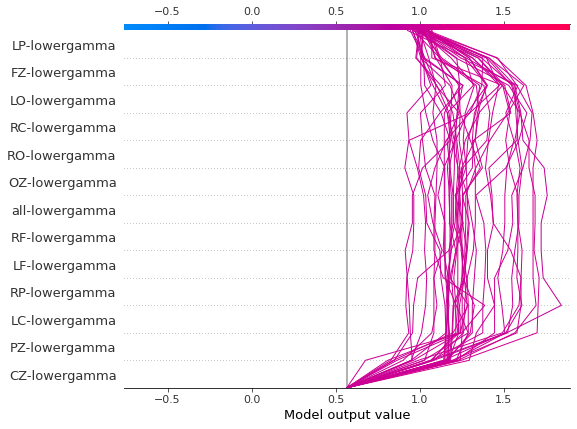

In [45]:
# feature names
feature_names = [col for col in power_gamma.columns]
ind = pd.DataFrame(test_indices[model_name], columns=['test_indices']).iloc[misclassified].query('test_indices == 40').index.tolist()
# ind2 = pd.DataFrame(test_indices[model_name], columns=['test_indices']).iloc[misclassified].query('test_indices == 69').index.tolist()
# [ind.append(i) for i in ind2]
j = 5  # index of the misclassified observation
miss =  [misclassified_obs[j] + i * 103 for i in range(40)] # indices for one obseration from the 40 iterations

# decision plot
# TODO: fix decision plot with different base values #TODO: make decition values identical with stratified CV.
shap.decision_plot(shap_values[model_name].base_values[ind][0],
                   shap_values[model_name].values[ind],
                   shap_values[model_name].data[ind],
                   feature_order='hclust',
                   feature_display_range = slice(-1, -14, -1),
                   feature_names=feature_names,
                   ignore_warnings=True)

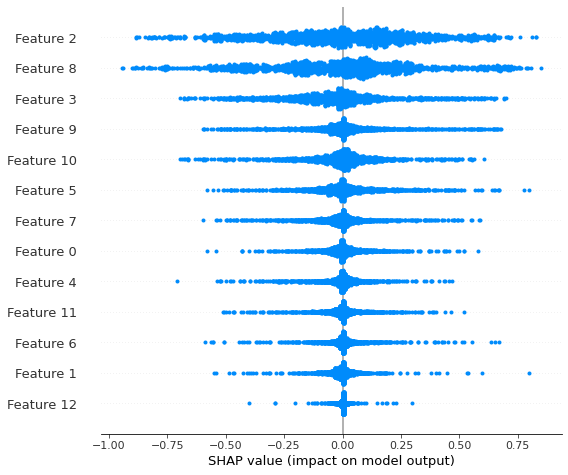

In [6]:
model_name = 'power sensor (gamma)'

misclassified_mask = np.where(y_preds[model_name] != y_tests[model_name])[0]
misclassified_mask_shap = shap_values[model_name].values[misclassified_mask]
shap.summary_plot(misclassified_mask_shap)

## Feature Importance Plots

In [33]:
# open data
with open('data/classification_results/importances.pkl', 'rb') as f:
    importances = pickle.load(f)

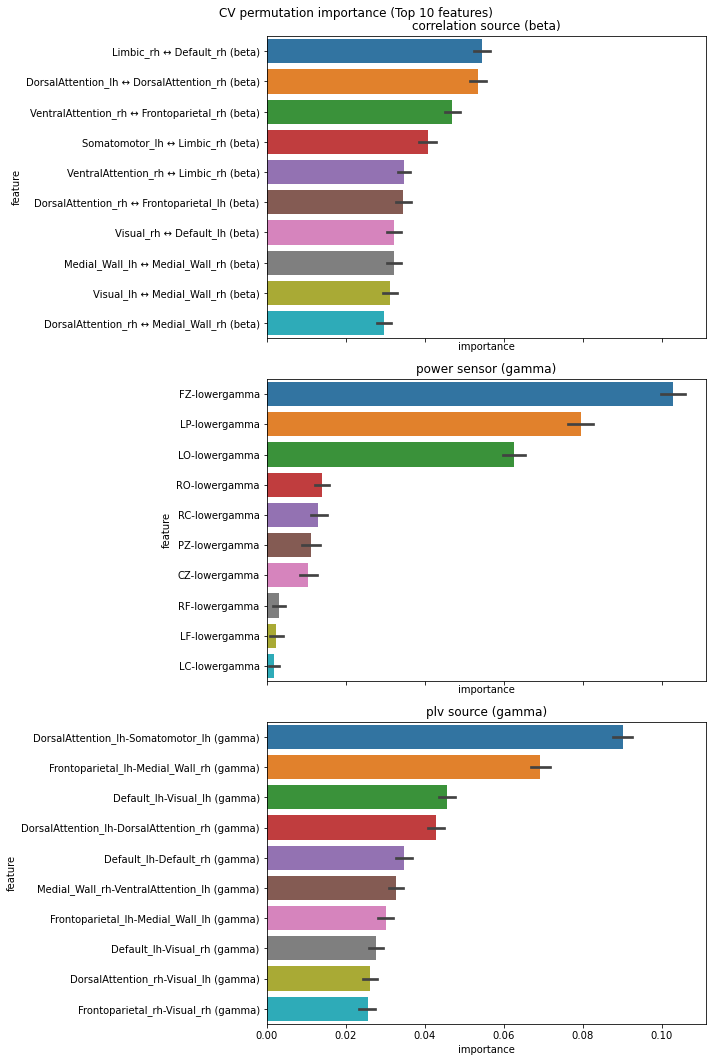

In [34]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 15))

for i, (model_name, model_importances) in enumerate(importances.items()):
    
    order = model_importances.mean(axis=0).sort_values(ascending=False).index
    importances_long = model_importances.melt(var_name='feature', value_name='importance')
    
    sns.barplot(data=importances_long, x='importance', y='feature', order=order[:10], ax=axes[i])
    
    axes[i].set_title(model_name)
plt.suptitle('CV permutation importance (Top 10 features)')
plt.tight_layout()
plt.show()